# Módulo 4 - Projeto 1: *support vector machines*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitores: Alana Santana -- alana.correia@ic.unicamp.br
           Hudson Bruno -- hudson.bruno@ic.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/456](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=456)

Instituto de Computação - Unicamp 2021

**Membros** <br>
André de Souza Gonçalves <br>
Victor Teodoro Goraieb <br>
Vitor Anastácio 


In [3]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

In [4]:
np.random.seed(1082141)
sns.set()

## Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [5]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 64 primeiras amostras no conjunto de treinamento

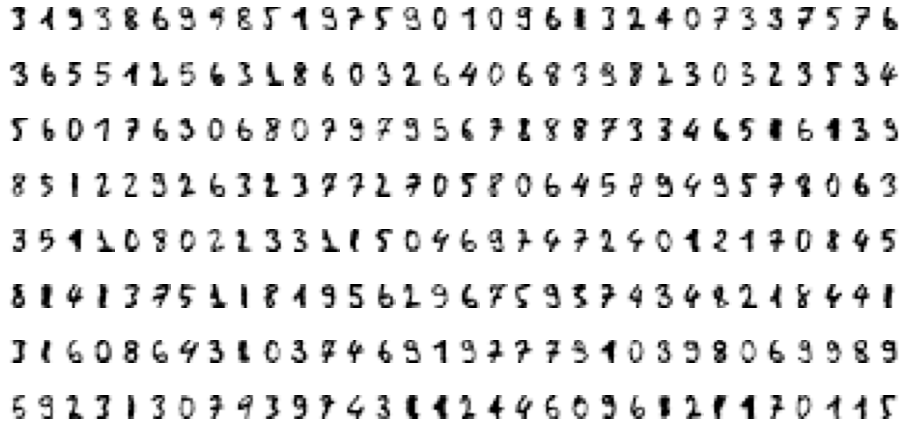

In [6]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


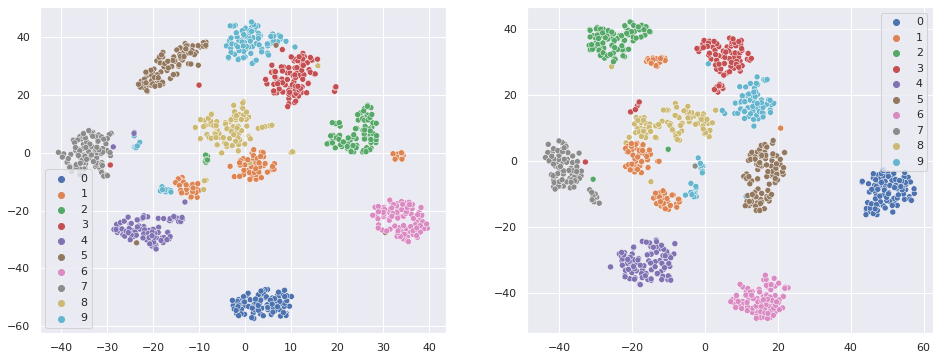

In [7]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


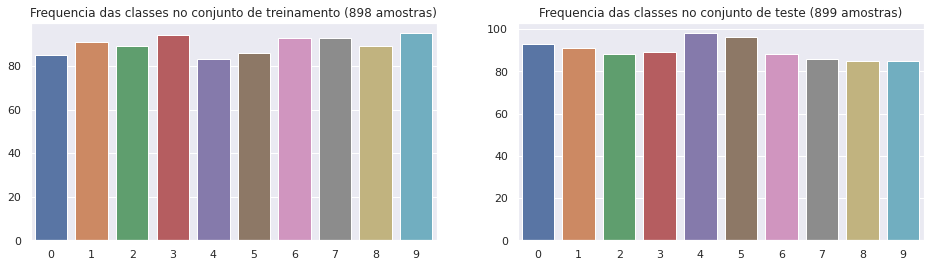

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos

**Atividade (3 pts):** defina e treine uma máquina de vetor de suporte com diferentes tipos de kernel, utilizando o scikit-learn. Avalie os diversos tipos de kernel e seus respectivos parâmetros com relação a qualidade da solução. Você deve separar uma parte do conjunto de treino para fazer a validação cruzada. Não utilize o conjunto de teste ainda.

Importando as bibliotecas utilizadas

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statistics import mean
from sklearn import svm
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix

Primeiramente, instanciamos 4 classificadores de SVM variando o kernel utilizado. Utilizamos os kernels linear, polinomial, RBF e sigmoid.

In [10]:
svm_linear_clf = svm.SVC(kernel='linear', C=1, random_state=0)
svm_poly_clf = svm.SVC(kernel='poly', C=1, random_state=0)
svm_rbf_clf = svm.SVC(kernel='rbf', C=1, random_state=0)
svm_sig_clf = svm.SVC(kernel='sigmoid', C=1, random_state=0)

classifiers = [svm_linear_clf, svm_poly_clf, svm_rbf_clf, svm_sig_clf]

In [11]:
# Função criada para realizar cross validation com Kfolding que retorna as acurácias balanceadas e F1 Scores para cada fold.
def cross_validation(x_train, y_train, classifier):
  
  kf = KFold(n_splits=5, shuffle=True, random_state=0)
  bal_acc_score_list = [] # Lista que guarda as acurácias balanceadas para cada fold
  f1_score_list = [] # Lista que guarda os F1 Scores para cada fold

  for train_index, val_index in kf.split(x_train):

    kf_x_train, kf_x_val = x_train[train_index], x_train[val_index]
    kf_y_train, kf_y_val = y_train[train_index], y_train[val_index]

    classifier.fit(kf_x_train, kf_y_train)
    y_pred = classifier.predict(kf_x_val)

    bal_acc_score_list.append(balanced_accuracy_score(kf_y_val, y_pred))
    f1_score_list.append(f1_score(kf_y_val, y_pred, average='micro', zero_division=0))

  return bal_acc_score_list, f1_score_list

Em seguida, utilizou-se a técnica de cross validation para cada um dos classificadores SVM. A média das acurácias balanceadas e a média do F1 Scores para cada fold para cada classficador foi armazenada em um DataFrame para comparativo dos resultados entre os mesmos.

In [12]:
results_df = []
for classifier in classifiers:
  
  bal_acc_scores, f1_scores = cross_validation(x_train,y_train, classifier)

  results_df.append({'kernel': classifier.kernel, 'balanced_accuracy': mean(bal_acc_scores), 'f1_score': mean(f1_scores)})

results_df = pd.DataFrame(results_df)

In [13]:
results_df

,kernel,balanced_accuracy,f1_score
0,linear,0.974500,0.973284
1,poly,0.979632,0.979963
2,rbf,0.980232,0.979963
3,sigmoid,0.899740,0.895369


Com isso, percebe-se que o SVM com kernels polinomial e RBF foram os que obtiveram melhores F1 Scores, e o SVM com kernel RBF foi o que obteve a melhor acurácia balanceada, sendo assim, o classificador escolhido para próximas análises. 

### Avaliando o modelo treinado

**Atividade (2 pts):** avalie o seu melhor modelo treinado no item anterior sobre o conjunto de teste previamente separado. Reporte a acurácia média, a matriz de confusão e outras métricas que achar válido.

Como visto anteriormente, o SVM com kernel RBF foi o melhor dentre os classificadores SVM com outros kernels. Com isso, treinou-se o modelo com todo conjunto de treino e previu-se as classificações no conjunto de teste.

In [14]:
svm_rbf_clf.fit(x_train, y_train)
y_test_pred = svm_rbf_clf.predict(x_test)

As métricas de acurácia balanceada e F1 Score foram bastante satisfatórias, atingindo aproximadamente 0.99 para ambas métricas.

In [15]:
print(balanced_accuracy_score(y_test_pred, y_test))
print(f1_score(y_test_pred, y_test, average='micro', zero_division=0))

0.9878314660625417
0.9877641824249166


A matriz de confusão relativa pode ser vista abaixo. Percebe-se que apenas o número 9 foi o que teve a pior classificação, mas ainda assim alta com 0.96.

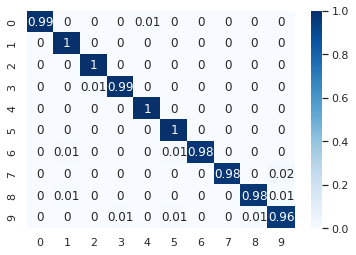

In [16]:
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test_pred), normalize='true').round(2), cmap='Blues', annot=True)

**Atividade (4 pts):** treine dois ou mais classificadores (Random forest, logistic regression, etc.) e reporte o suas respectivas métricas sobre as porções de validação separadas (acurácia, acurácia balanceada, precision, etc). Compare seus melhores classificadores com os resultados da SVM no conjunto de teste. 



Após os resultados vistos com o modelo de SVM com kernl RBF, avaliou-se os resultados de outros modelos de classificação. Os modelos avaliados foram Random Forest, Decision Tree, Logistic Classificer e XG Boost.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

Assim como nas avaliações com SVM, utilizamos cross validation com K Folding para decidir qual entre os modelos avaliados será o escolhido para comparar com os resultados obtidos com SVM. A média das acurácias balanceadas e a média de F1 Scores para cada fold e modelos foi armazenada em um DataFrame para comparação dos resultados.

In [18]:
classifiers_df = [] # DataFrame que armazenará os resultados dos modelos avaliados.

In [19]:
rf_clf = RandomForestClassifier()
bal_acc_scores, f1_scores = cross_validation(x_train,y_train, rf_clf)
classifiers_df.append({'classifier': 'Random Forest', 'balanced_accuracy': mean(bal_acc_scores), 'f1_score': mean(f1_scores)})

In [20]:
dt_clf = DecisionTreeClassifier()
bal_acc_scores, f1_scores = cross_validation(x_train,y_train, dt_clf)
classifiers_df.append({'classifier': 'Decision Tree', 'balanced_accuracy': mean(bal_acc_scores), 'f1_score': mean(f1_scores)})

In [21]:
lr_clf = LogisticRegression(max_iter= 100000)
bal_acc_scores, f1_scores = cross_validation(x_train,y_train, lr_clf)
classifiers_df.append({'classifier': 'Logistic', 'balanced_accuracy': mean(bal_acc_scores), 'f1_score': mean(f1_scores)})

In [22]:
xgb_clf = XGBClassifier()
bal_acc_scores, f1_scores = cross_validation(x_train,y_train, xgb_clf)
classifiers_df.append({'classifier': 'XG Boosting', 'balanced_accuracy': mean(bal_acc_scores), 'f1_score': mean(f1_scores)})

In [23]:
classifiers_df = pd.DataFrame(classifiers_df)
classifiers_df

,classifier,balanced_accuracy,f1_score
0,Random Forest,0.958070,0.956561
1,Decision Tree,0.823321,0.826238
2,Logistic,0.969291,0.967722
3,XG Boosting,0.933637,0.932092


Percebe-se que o modelo de classificação logística foi o melhor dentre os classificadores avaliados. Com isso, avaliou-se seu desempenho com todo conjunto de treino e avaliação das métricas de acurácia balanceada e F1 Score para o conjunto de teste.

In [24]:
lr_clf = LogisticRegression(max_iter= 100000)
lr_clf.fit(x_train, y_train)
y_test_pred_lr = classifier.predict(x_test)

In [25]:
print(balanced_accuracy_score(y_test_pred_lr, y_test))
print(f1_score(y_test_pred_lr, y_test, average='micro', zero_division=0))

0.9158528075155189
0.9087875417130145


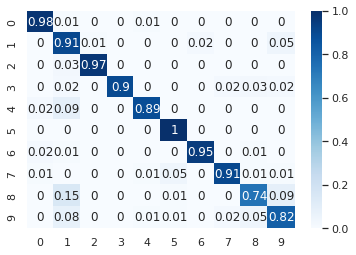

In [26]:
sns.heatmap(confusion_matrix(y_test, y_test_pred_lr, labels=np.unique(y_test), normalize='true').round(2), cmap='Blues', annot=True)

**Pergunta (1pt):** qual classificador apresentou os melhores resultados? Qual critério você utilizou para definir sua escolha? Discuta.

Após avaliar os resultados de classificadores SVM com quatro kernels diferentes e avaliar outros quatro modelos de classficação, o melhor modelo obtido para o conjunto de teste foi o SVM com kernel RBF. Este aconseguiu aproximadamente 0,99 de acurácia balanceada e de F1 Score e teve melhor matriz de confusão relativa, ficando pelo menos acima 8 pontos percentuais do melhor dos demais modelos que não utilizaram SVM. Vale notar que apenas o classificador SVM com kernel sigmoid não foi superior a todos os últimos quatro modelos testados. Todos os demais kernels desempenharam melhor que esses últimos.